In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("nameses/girl_names.txt", "r").read().splitlines()
words = [word.lower() for word in words]
words[:8]

['abel', 'abelone', 'abigael', 'abigail', 'ada', 'adela', 'adelaide', 'adele']

In [3]:
len(words)

3046

In [4]:
# Building out vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ä', 28: 'å', 29: 'æ', 30: 'ç', 31: 'é', 32: 'ø', 0: '.'}
33


In [5]:
# Buliding the dataset with splits
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

torch.Size([17019, 3]) torch.Size([17019])
torch.Size([2145, 3]) torch.Size([2145])
torch.Size([2065, 3]) torch.Size([2065])


## Main code

In [38]:
# OOP is OP

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum + xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum + xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
        
n_embd = 10 # the dimensionality of the character embedding  vectors
n_hidden= 100 # number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: applky gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total parameters:" ,sum(p.nelement() for p in parameters)) # number of total trainable parameters
for p in parameters:
    p.requires_grad = True

Total parameters: 48229


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
# ud = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 10**-1 if i < 100000 else 100**-1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # with torch.no_grad():
        # ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
        # break # AFTER_DEBUG: Would obvioulsy remove to run full optimization

      0/ 200000: 4.6483
  10000/ 200000: 2.1865
  20000/ 200000: 1.7334
  30000/ 200000: 2.2932
  40000/ 200000: 1.7355


layer 2 (      Tanh): mean +0.01, std 0.73, saturated: 18.78%
layer 5 (      Tanh): mean -0.01, std 0.76, saturated: 20.62%
layer 8 (      Tanh): mean -0.01, std 0.78, saturated: 22.56%
layer 11 (      Tanh): mean -0.00, std 0.80, saturated: 24.75%
layer 14 (      Tanh): mean +0.02, std 0.82, saturated: 28.97%


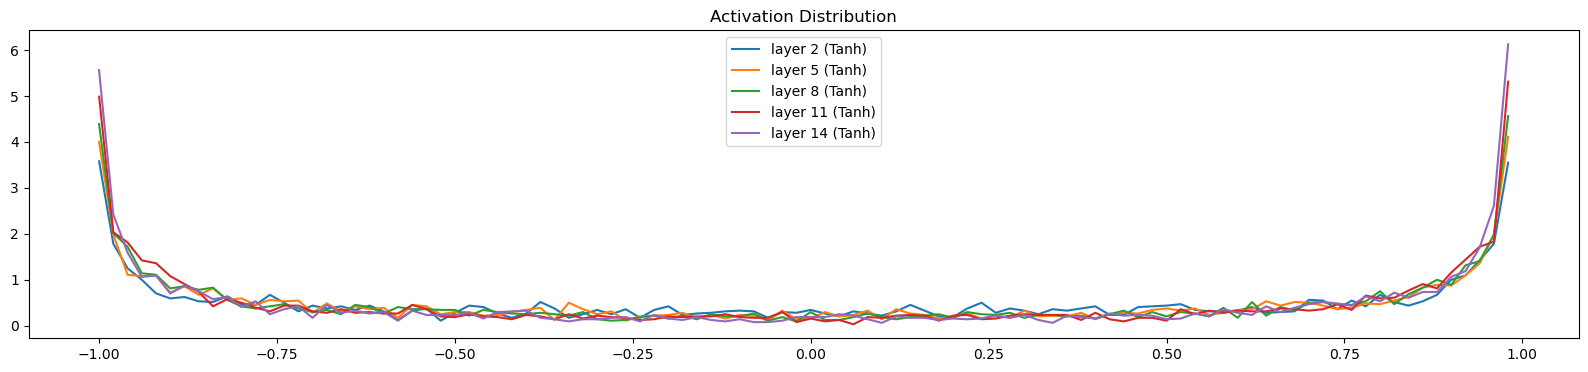

In [40]:
# Visualize Tanh histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')
plt.show();

layer 2 (      Tanh): mean -0.000000, std 4.601745e-03
layer 5 (      Tanh): mean -0.000000, std 4.798053e-03
layer 8 (      Tanh): mean +0.000000, std 4.759657e-03
layer 11 (      Tanh): mean -0.000000, std 4.463311e-03
layer 14 (      Tanh): mean -0.000000, std 5.386517e-03


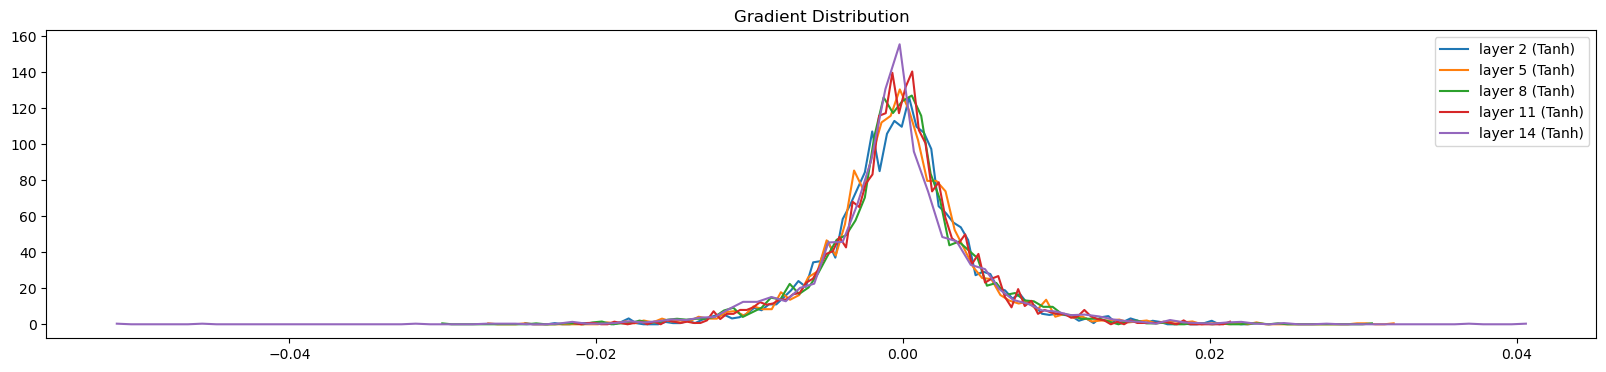

In [41]:
# Visualize Tanh histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')
plt.show();

weight   (33, 10) | mean -0.000000 | std 1.481044e-02 | grad:data ratio 1.300687e-02
weight  (30, 100) | mean -0.000032 | std 8.980114e-03 | grad:data ratio 1.928064e-02
weight (100, 100) | mean -0.000049 | std 6.390032e-03 | grad:data ratio 2.203351e-02
weight (100, 100) | mean -0.000037 | std 6.769793e-03 | grad:data ratio 2.355069e-02
weight (100, 100) | mean +0.000055 | std 6.982612e-03 | grad:data ratio 2.514949e-02
weight (100, 100) | mean -0.000129 | std 6.094025e-03 | grad:data ratio 2.304484e-02
weight  (100, 33) | mean -0.000114 | std 9.561635e-03 | grad:data ratio 2.572704e-02


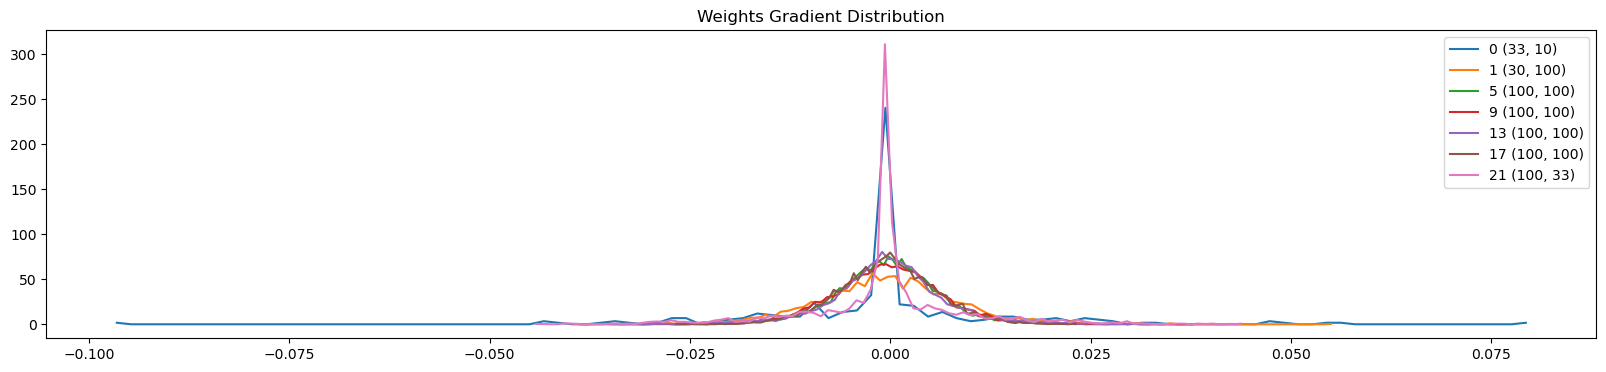

In [42]:
# Visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % ((tuple(p.shape)), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')
plt.show();

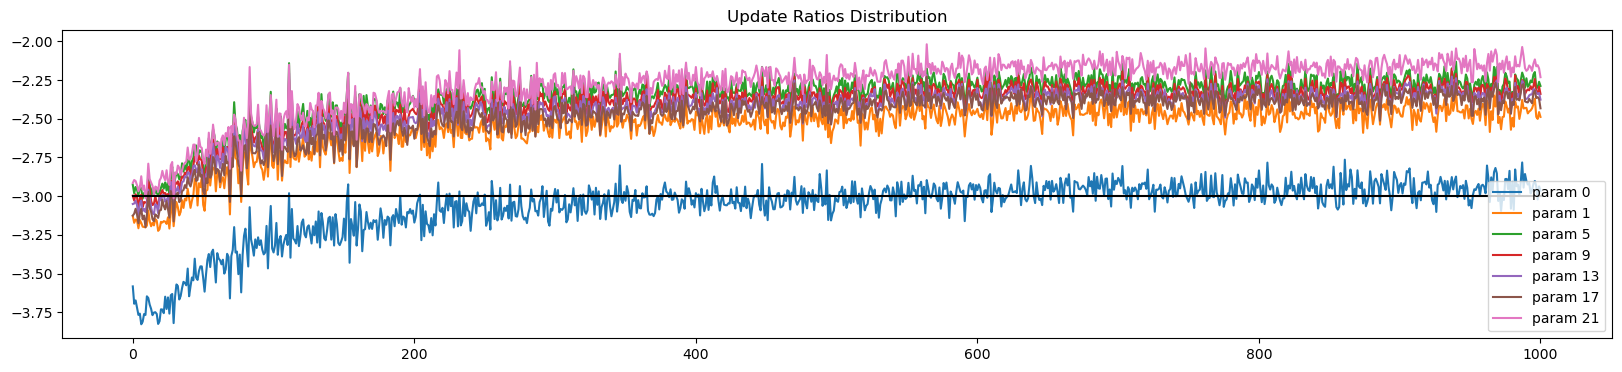

In [43]:
# Visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate 
plt.legend(legends);
plt.title('Update Ratios Distribution')
plt.show();

In [51]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y) # loss function
    print(split, loss.item())

# Make batch norm ready for inference
if isinstance(layer, BatchNorm1d):
        layer.training = False
split_loss('train')
split_loss('val')

train 4.348443508148193
val 4.331140041351318


In [73]:
(h == 1).unique(return_counts=True)

(tensor([False]), tensor([6400]))

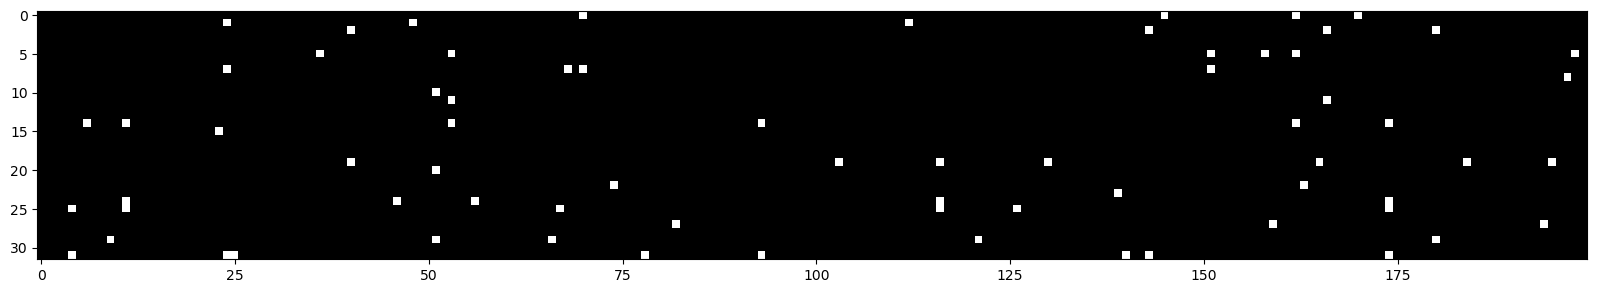

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.show();

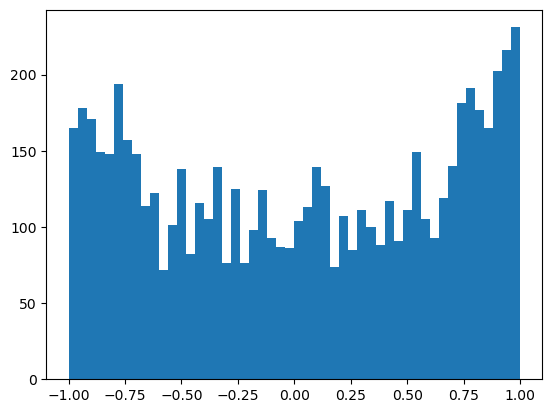

In [75]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

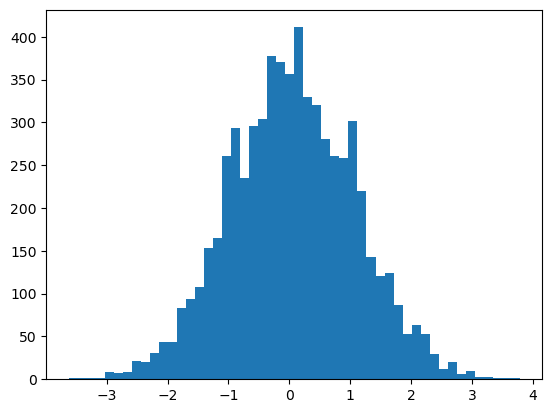

In [76]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

In [49]:
# issue with initialization - we expect first loss to be:
-torch.tensor(1/33.).log()

tensor(3.4965)

tensor(0.0006) tensor(1.0051)
tensor(-0.0013) tensor(0.9873)


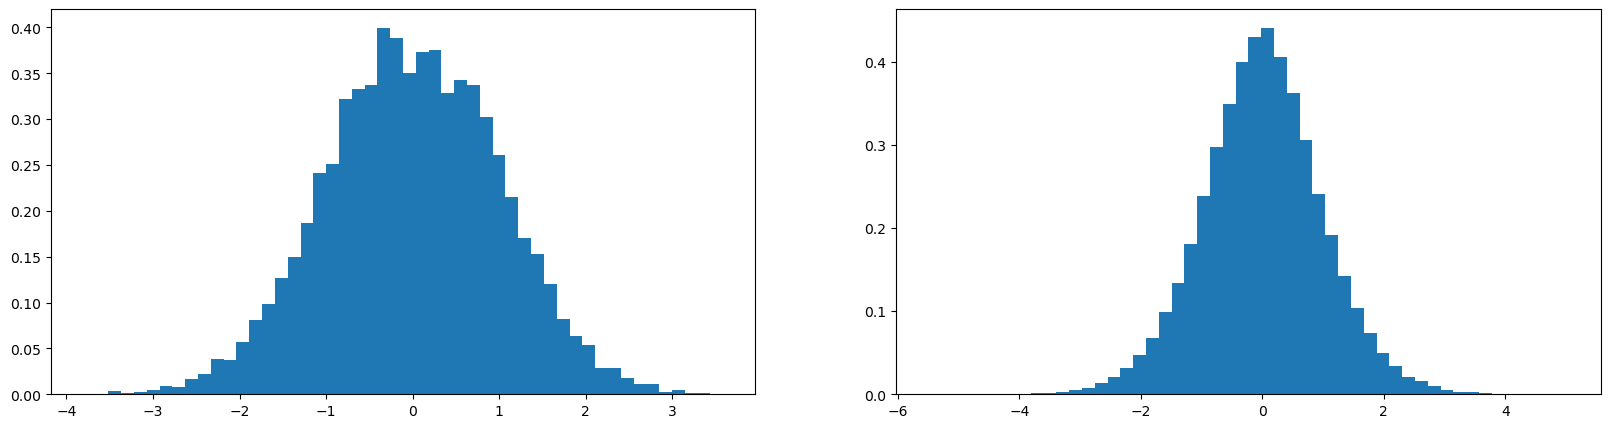

In [86]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

## Drawing sample names 

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

In [132]:
# Andrejs variant
g = torch.Generator().manual_seed(2147483647)  # Set the random seed for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() 

        # shift the context window and track the samples
        context = context[1:] + [ix] 
        out.append(ix)
        
        # if samples special character "." -> break
        if ix == 0: 
            break
    print("".join(itos[i] for i in out))

junine.
jana.
adolfrida.
elin.
maire.
toriane.
guri.
signy.
urd.
ilde.
aishbyanne.
irja.
sirpa.
ayla.
thorgfrid.
hilde.
maj.
penny.
wilhelen.
cora.


In [ ]:
[name for name in words if "urd" in name]

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));